In [20]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from nltk.corpus import stopwords
import nltk

# Ensure stopwords are downloaded
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
# 1. Load Dataset
# =========================
df = pd.read_csv("../../data/maildata.csv")
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


In [22]:
# 2. Preprocessing
# =========================
df.rename(columns={'Message': 'text', 'Category': 'label'}, inplace=True)
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

print(df['label_num'].value_counts())

label_num
0    4825
1     747
Name: count, dtype: int64


In [23]:
# 3. Text Cleaning
# =========================
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)  # remove URLs
    text = re.sub(r"\d+", " ", text)  # remove numbers
    text = re.sub(r"[^a-z@$% ]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

df['clean_text'] = df['text'].apply(clean_text)

In [24]:
# 4. Feature Engineering
# =========================
df['email_length'] = df['text'].apply(lambda x: len(str(x)))
df['num_links'] = df['text'].apply(lambda x: len(re.findall(r"http\S+|www\S+", str(x))))
df['num_uppercase'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
df['num_special_chars'] = df['text'].apply(lambda x: len(re.findall(r"[^a-zA-Z0-9\s]", str(x))))


In [25]:
# 5. Split Data
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    df[['clean_text', 'email_length', 'num_links', 'num_uppercase', 'num_special_chars']],
    df['label_num'],
    test_size=0.2,
    random_state=42,
    stratify=df['label_num']
)

In [26]:
# 6. TF-IDF Vectorization
# =========================
tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    stop_words=stopwords.words('english'),
    sublinear_tf=True
)

# Custom transformer to extract numeric features
class NumericFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X[['email_length', 'num_links', 'num_uppercase', 'num_special_chars']])

In [27]:
# 7. Combine TF-IDF and Numeric Features
# =========================
class TextAndFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, vectorizer, numeric_transformer):
        self.vectorizer = vectorizer
        self.numeric_transformer = numeric_transformer

    def fit(self, X, y=None):
        self.vectorizer.fit(X['clean_text'])
        self.numeric_transformer.fit(X)
        return self

    def transform(self, X):
        text_features = self.vectorizer.transform(X['clean_text'])
        numeric_features = self.numeric_transformer.transform(X)
        return hstack([text_features, numeric_features])

feature_union = TextAndFeatures(tfidf, NumericFeatures())

In [29]:
# 8. SVM Model + GridSearchCV
# =========================
pipeline = Pipeline([
    ('features', feature_union),
    ('svm', SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42))
])

param_grid = {
    'svm__C': [0.1, 1, 5, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

print("\nBest Parameters from GridSearchCV:", grid_search.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   4.6s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   4.7s
[CV] END .......svm__C=0.1, svm__gamma=auto, svm__kernel=rbf; total time=   4.6s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   6.5s
[CV] END .......svm__C=0.1, svm__gamma=auto, svm__kernel=rbf; total time=   6.1s
[CV] END .......svm__C=0.1, svm__gamma=auto, svm__kernel=rbf; total time=   6.2s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   4.5s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   5.0s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   4.8s
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__kernel=linear; total time=  17.9s
[CV] END .........svm__C=1, svm__gamma=auto, svm__kernel=rbf; total time=   3.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  22.5s
[CV] END ....svm__C=0.1, svm


Accuracy: 0.9829596412556054

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.95      0.92      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



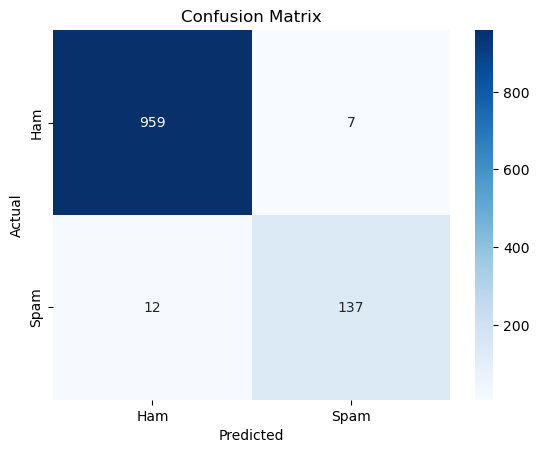

In [31]:
# 9. Evaluate Best Model
# =========================
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [32]:
# 10. Save Model & Vectorizer
# =========================
joblib.dump(best_model, 'svm_spam_model_optimized.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer_optimized.pkl')

['tfidf_vectorizer_optimized.pkl']

In [34]:
# 11. Predict User Input
# =========================
def predict_email_user_input():
    email_text = input("Enter the email content:\n\n")

    # Clean input
    text_clean = clean_text(email_text)

    # Extract extra features
    email_length = len(email_text)
    num_links = len(re.findall(r"http\S+|www\S+", email_text))
    num_uppercase = sum(1 for c in email_text if c.isupper())
    num_special_chars = len(re.findall(r"[^a-zA-Z0-9\s]", email_text))

    sample_df = pd.DataFrame([{
        'clean_text': text_clean,
        'email_length': email_length,
        'num_links': num_links,
        'num_uppercase': num_uppercase,
        'num_special_chars': num_special_chars
    }])

    pred = best_model.predict(sample_df)

    if pred[0] == 1:
        print("\nThe message is classified as: SPAM 🚨")
    else:
        print("\nThe message is classified as: HAM ✅")

predict_email_user_input()  # Uncomment to test interactively


The message is classified as: HAM ✅
